## Can Twitter help predict stock prices?

Authors: Noah Mukhtar, Ramy Hammam and Venkatesh Chandra

Description: 

Import regular libraries

# Import all libraries

In [0]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import io
from google.colab import files

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

In [0]:
pip install vaderSentiment

In [0]:
from sklearn.preprocessing import StandardScaler
import pandas_datareader.data as web
import math
#import xlsxwriter
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime as dt

# Analytical Dataset

Importing the dataset
The dataset was downloaded from http://followthehashtag.com/datasets/nasdaq-100-companies-free-twitter-dataset/. The website contains tweets mentioning any NASDAQ 100 Twitter Symbol of different companies for a 79 day period (3/28/16 to 6/15/16) .

Tweets for Electronic Arts

In [0]:
uploaded = files.upload()

Saving EA_sports_tweets_cleaned.csv to EA_sports_tweets_cleaned.csv


In [0]:
df = pd.read_csv(io.BytesIO(uploaded['EA_sports_tweets_cleaned.csv']))
df.columns

Index(['Tweet Id', 'Date', 'Hour', 'User Name', 'Nickname', 'Bio',
       'Tweet content', 'Favs', 'RTs', 'Latitude', 'Longitude', 'Country',
       'Place (as appears on Bio)', 'Profile picture', 'Followers',
       'Following', 'Listed', 'Tweet language (ISO 639-1)', 'Tweet Url',
       'Is a RT', 'Original Tweet User Name', 'User Mentions', 'Hashtags',
       'Symbols', 'Media', 'URLs'],
      dtype='object')

Filter for required columns

In [0]:
df = df[['Date','Tweet content','Followers']]
df.head(2)

,Date,Tweet content,Followers
0,2016-06-15,"#VR hardware is here, but robust game lineup i...",5172.0
1,2016-06-15,OVAS Pacific Biosciences of California Inc. Ex...,71.0


Create a function using VADER library to extract dentiment scores

In [0]:
def sentimentScore(Tweet):
    analyzer = SentimentIntensityAnalyzer()
    score_values = []
    for tweet in df['Tweet content']:
        vs1 = analyzer.polarity_scores(tweet)
        print("Score: " + str(vs1))
        score_values.append(vs1)
    return score_values

In [0]:
sentiment_scores = pd.DataFrame(sentimentScore(df['Tweet content']))

Score: {'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.4767}
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Score: {'neg': 0.292, 'neu': 0.708, 'pos': 0.0, 'compound': -0.5106}
Score: {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'compound': 0.5106}
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Score: {'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.5106}
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Score: {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.5106}
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Score: {'neg': 0.102, 'neu': 0.683, 'pos': 0.215, 'compound': 0.3182}
Score: {'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.296}
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Score: {'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compound': 0.5859}
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Score: {'neg': 0.0, 'neu': 0.84

Filter for tweets within the 74 day time period

In [0]:
raw_ads = pd.merge(df, sentiment_scores, left_index=True, right_index=True)
raw_ads = raw_ads[(raw_ads['Date'] >= '2016-04-01') & (raw_ads['Date'] <= '2016-06-14')]

Change the date column to date time format

In [0]:
raw_ads['datetime'] = pd.to_datetime(raw_ads['Date'])

In [0]:
raw_ads.head()

,Date,Tweet content,Followers,neg,neu,pos,compound,datetime
33,2016-06-14,$EA:\n\nElectronic Arts Follows Activision Int...,767.0,0.000,1.000,0.000,0.0000,2016-06-14
34,2016-06-14,$EA:US EA Gives a Peek Into Its 'Star Wars' Pl...,2767.0,0.159,0.841,0.000,-0.5574,2016-06-14
35,2016-06-14,https://t.co/ipALk92X8U Learn Jason Bonds Tra...,4.0,0.000,0.739,0.261,0.5972,2016-06-14
36,2016-06-14,RT @TheStreet: Catch up with $EA CEO Andrew Wi...,1357.0,0.000,1.000,0.000,0.0000,2016-06-14
37,2016-06-14,Catch up with $EA CEO Andrew Wilson https://t....,476572.0,0.000,1.000,0.000,0.0000,2016-06-14


Filter for non-neutral tweets

In [0]:
raw_ads_2 = raw_ads[(raw_ads['compound'] !=0)]

In [0]:
len(raw_ads_2)

2057

To add the influence power of the tweeter to the tweet sentiment, we multiply the number of followers with the compound value to obtain sentiment_score.

Note - Filter for tweeters having >0 followers

In [0]:
raw_ads_3 = raw_ads_2[raw_ads_2['Followers'].isnull()==False]
raw_ads_3.head(2)

,Date,Tweet content,Followers,neg,neu,pos,compound,datetime
34,2016-06-14,$EA:US EA Gives a Peek Into Its 'Star Wars' Pl...,2767.0,0.159,0.841,0.000,-0.5574,2016-06-14
35,2016-06-14,https://t.co/ipALk92X8U Learn Jason Bonds Tra...,4.0,0.000,0.739,0.261,0.5972,2016-06-14


In [0]:
raw_ads_3['sentiment_score'] = raw_ads_3['compound']*raw_ads_3['Followers']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
raw_ads_3.reset_index()
raw_ads_3.head(2)

,Date,Tweet content,Followers,neg,neu,pos,compound,datetime,sentiment_score
34,2016-06-14,$EA:US EA Gives a Peek Into Its 'Star Wars' Pl...,2767.0,0.159,0.841,0.000,-0.5574,2016-06-14,-1542.3258
35,2016-06-14,https://t.co/ipALk92X8U Learn Jason Bonds Tra...,4.0,0.000,0.739,0.261,0.5972,2016-06-14,2.3888


# Preparing the dataset for machine learning

Take daily average of values to prepare the timeseries data

In [0]:
raw_ads_4=(raw_ads_3.groupby(raw_ads_3.Date).mean())

# Y variable: Yahoo Finance data

In [0]:
ticker = input("Enter ticker")

Enter tickerEA


In [0]:
initial_date = dt.datetime(2016, 4, 2)
final_date =  dt.datetime(2016, 6, 14)

stock_data = web.DataReader(ticker, 'yahoo', initial_date, final_date)

In [0]:
stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-04-04,66.489998,65.379997,66.000000,65.739998,2029600,65.739998
2016-04-05,65.959999,65.050003,65.099998,65.449997,2281800,65.449997
2016-04-06,66.070000,65.250000,65.669998,65.830002,1652900,65.830002
2016-04-07,65.910004,63.669998,65.699997,63.930000,2921700,63.930000
2016-04-08,64.699997,63.279999,64.120003,64.239998,2352000,64.239998


In [0]:
stock_data.columns = ['High','Low','Open','Close','Volume_of_stock','Adj_Close_stock']

Daily change in stock calculation and standardizing the value

In [0]:
stock_data['stock_val_change'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open'] * 100.0

In [0]:
scaler = StandardScaler()
stock_data['stock_val_change_scaled'] = scaler.fit_transform(stock_data[['stock_val_change']])
stock_data.head(2)

,High,Low,Open,Close,Volume_of_stock,Adj_Close_stock,stock_val_change,stock_val_change_scaled
Date,,,,,,,,
2016-04-04,66.489998,65.379997,66.000000,65.739998,2029600,65.739998,-0.393943,-0.428264
2016-04-05,65.959999,65.050003,65.099998,65.449997,2281800,65.449997,0.537632,0.284800


Combine the dataframes

Note that weekend values are not present

In [0]:
dataset = pd.merge(stock_data[['Open', 'Volume_of_stock','Adj_Close_stock','stock_val_change', 'stock_val_change_scaled']], raw_ads_4[['sentiment_score']], left_index=True, right_index=True)

Add predicted stock value change

In [0]:
forecast_col = 'stock_val_change'
forecast_out = int(math.ceil(0.013 * len(dataset)))
dataset['stock_val_change_pred'] = dataset[forecast_col].shift(-forecast_out)

In [0]:
dataset.head(2)

,Open,Volume_of_stock,Adj_Close_stock,stock_val_change,stock_val_change_scaled,sentiment_score,stock_val_change_pred
Date,,,,,,,
2016-04-04,66.000000,2029600,65.739998,-0.393943,-0.428264,10306.439956,0.537632
2016-04-05,65.099998,2281800,65.449997,0.537632,0.284800,931.380138,0.243648


Add a stock buy/sell column

In [0]:
dataset['buy_sell'] = dataset['stock_val_change_pred'].apply(lambda x: 1 if x >=0 else -1)

In [0]:
dataset.head()

,Open,Volume_of_stock,Adj_Close_stock,stock_val_change,stock_val_change_scaled,sentiment_score,stock_val_change_pred,buy_sell
Date,,,,,,,,
2016-04-04,66.000000,2029600,65.739998,-0.393943,-0.428264,10306.439956,0.537632,1
2016-04-05,65.099998,2281800,65.449997,0.537632,0.284800,931.380138,0.243648,1
2016-04-06,65.669998,1652900,65.830002,0.243648,0.059773,419.680444,-2.694059,-1
2016-04-07,65.699997,2921700,63.930000,-2.694059,-2.188862,-225.191773,0.187141,1
2016-04-08,64.120003,2352000,64.239998,0.187141,0.016520,1378.595694,-1.910234,-1


# Build the models

This is a time series data, we can do a random train test split for binary classification prediction of Buy or Sell, but we also want to incorporate the stock price, so we will split based on row id

In [0]:
train_set = dataset.iloc[:35]
test_set = dataset.iloc[35:]

X_train = np.array(train_set[['sentiment_score']])
X_test = np.array(test_set[['sentiment_score']])

y_train = np.array(train_set['buy_sell'])
y_test = np.array(test_set['buy_sell'])

Standardize the feature set

In [0]:
scaler = StandardScaler()
X_train_std= scaler.fit_transform(X_train)

Train and Validation set split

# KNN Algorithm

EA: 56% accuracy with k=2

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for i in range(1,5):
    knn = KNeighborsClassifier(n_neighbors=i).fit(X_train_std, y_train)
    y_test_pred = knn.predict(X_test)
    print(accuracy_score(y_test, y_test_pred))

0.5
0.5625
0.5
0.5625


Adding to the list

In [0]:
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_test_pred = knn.predict(X_test)

knn_list =[]
knn_list.append(y_test_pred)

# SVM

Accuracy:

Linear kernel: EA 43%

rbf kernel: EA 60%

poly kernel: EA 43%

sigmoid kernel: EA 46%

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

for i in range(1,5):
    svc= SVC(kernel="linear", random_state=0, gamma=i)
    model= svc.fit(X_train_std, y_train)
    scores = cross_val_score(estimator=model, X=X_train_std, y=y_train, cv=5)
    print(i, ':', np.average(scores))

1 : 0.42857142857142855
2 : 0.42857142857142855
3 : 0.42857142857142855
4 : 0.42857142857142855


In [0]:
from sklearn.model_selection import cross_val_score
for i in range(1,5):
    svc= SVC(kernel="rbf", random_state=0, gamma=i)
    model= svc.fit(X_train_std, y_train)
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
    print(i, ':', np.average(scores))

1 : 0.5714285714285714
2 : 0.5714285714285714
3 : 0.5714285714285714
4 : 0.5999999999999999


In [0]:
from sklearn.model_selection import cross_val_score
for i in range(1,5):
    svc= SVC(kernel="poly", random_state=0, gamma=i)
    model= svc.fit(X_train_std, y_train)
    scores = cross_val_score(estimator=model, X=X_train_std, y=y_train, cv=5)
    print(i, ':', np.average(scores))

1 : 0.42857142857142855
2 : 0.42857142857142855
3 : 0.42857142857142855
4 : 0.42857142857142855


In [0]:
from sklearn.model_selection import cross_val_score
for i in range(1,5):
    svc= SVC(kernel="sigmoid", random_state=0, gamma=i)
    model= svc.fit(X_train_std, y_train)
    scores = cross_val_score(estimator=model, X=X_train_std, y=y_train, cv=5)
    print(i, ':', np.average(scores))

1 : 0.45714285714285713
2 : 0.45714285714285713
3 : 0.45714285714285713
4 : 0.45714285714285713


Add to the list

In [0]:
svc= SVC(kernel="rbf", random_state=0, gamma=3)
model= svc.fit(X_train_std, y_train)
y_test_pred = model.predict(X_test)

svmlist =[]
svmlist.append(y_test_pred)

# Decision Tree

Accuracy:

EA - 50%

In [0]:
# Cross-validation
from sklearn.tree import DecisionTreeClassifier

decisiontree= DecisionTreeClassifier(max_depth=4)
model = decisiontree.fit(X_train_std, y_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

#Add to the list
dtlist =[]
dtlist.append(y_test_pred)

In [0]:
X_train_std

array([[ 0.87573495],
       [-0.1158118 ],
       [-0.16993137],
       [-0.23813583],
       [-0.06851236],
       [-0.07963342],
       [-0.12612125],
       [-0.19127028],
       [-0.2576075 ],
       [-0.09128601],
       [-0.15327901],
       [-0.1704801 ],
       [-0.18544281],
       [-0.20550478],
       [-1.35607969],
       [-0.26529632],
       [-0.04741901],
       [-0.04083643],
       [-0.1336877 ],
       [-0.17824545],
       [-0.18387852],
       [-0.19248511],
       [-0.11237631],
       [-0.14014769],
       [-0.29584169],
       [-0.28159379],
       [ 5.59098602],
       [-0.03108179],
       [ 0.00634292],
       [-0.11754693],
       [-0.45504247],
       [ 0.05724475],
       [-0.19853034],
       [-0.15236724],
       [-0.29483564]])

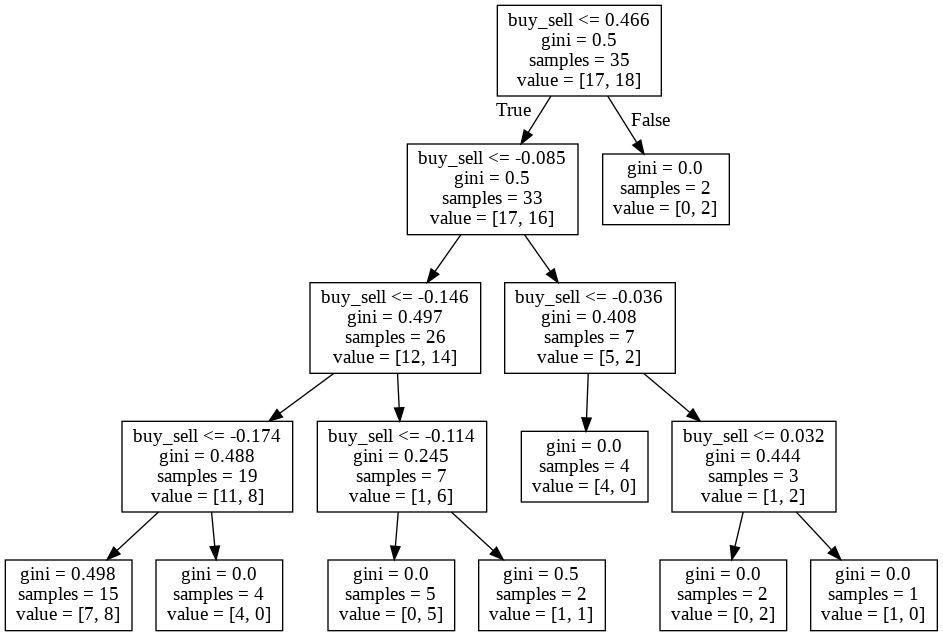

In [0]:
#Visualize the tree
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image

features = ['buy_sell']

dot_data = StringIO()  
tree.export_graphviz(decisiontree, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Random Forest

Accuracy

EA - 50%

In [0]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(random_state=5, bootstrap=0, n_estimators=1000)

model=randomforest.fit(X_train_std, y_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

#Add to the list
rflist = []
rflist.append(y_test_pred)

# Logistic Regression

Accuracy:

EA - 56.25%

In [0]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
model = lr.fit(X_train_std, y_train)

In [0]:
# Calculate the accuracy score
from sklearn import metrics
y_test_pred = lr.predict(X_test)
print(metrics.accuracy_score(y_test,y_test_pred))

#Add to te list
lrlist=[]
lrlist.append(y_test_pred)

0.5625


# Artificial Neural Network

Accuracy:

EA: 54%

In [0]:
#Finding the parameters to build the best net
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

import numpy
for i in range(2,21):
    model4= MLPClassifier(hidden_layer_sizes=(i),max_iter=1000)
    scores= cross_val_score(estimator= model4, X=X_train_std, y=y_train, cv=5)
    print(i, '-', numpy.average(scores))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2 - 0.5428571428571429
3 - 0.48571428571428565
4 - 0.45714285714285713
5 - 0.48571428571428565
6 - 0.4
7 - 0.45714285714285713
8 - 0.3714285714285714
9 - 0.5428571428571429
10 - 0.42857142857142855
11 - 0.3714285714285714
12 - 0.48571428571428565
13 - 0.3714285714285714
14 - 0.39999999999999997
15 - 0.42857142857142855
16 - 0.3714285714285714
17 - 0.39999999999999997
18 - 0.42857142857142855
19 - 0.45714285714285713
20 - 0.34285714285714286


Add to the list

In [0]:
#Add to te list
mlp = MLPClassifier(hidden_layer_sizes=(2), max_iter=1000)
model = mlp.fit(X_train_std, y_train)
y_test_pred = model.predict(X_test)

annlist=[]
annlist.append(y_test_pred)

# Analyzing the performance of the models

EA Block

Best model - KNN (k=3)

In [0]:
outcome_df = pd.DataFrame({'Regular': y_test, 'KNN': knn_list[0], 'SVM': svmlist[0], 'Decision_Tree': dtlist[0], 'Random_Forest': rflist[0], 'Logistic': lrlist[0], 'ANN': annlist[0]})

In [0]:
predictions = pd.merge(dataset.iloc[35:].reset_index(), outcome_df, left_index=True, right_index = True)

In [0]:
predictions.head(2)

,Date,Open,Volume_of_stock,Adj_Close_stock,stock_val_change,stock_val_change_scaled,sentiment_score,stock_val_change_pred,buy_sell,Regular,KNN,SVM,Decision_Tree,Random_Forest,Logistic,ANN
0,2016-05-23,73.389999,3248300,73.239998,-0.204390,-0.283173,991.692205,2.266556,1,1,1,1,1,1,1,1
1,2016-05-24,73.680000,3781500,75.349998,2.266556,1.608185,1509.755229,-0.596892,-1,-1,-1,1,1,1,1,1


Predictions

In [0]:
predictions["Gain_or_Loss_KNN"] = (predictions['Adj_Close_stock'] - predictions['Open'])*predictions['KNN']
predictions["Gain_or_Loss_SVM"] = (predictions['Adj_Close_stock'] - predictions['Open'])*predictions['SVM']
predictions["Gain_or_Loss_DecisionTree"] = (predictions['Adj_Close_stock'] - predictions['Open'])*predictions['Decision_Tree']
predictions["Gain_or_Loss_Random_Forest"] = (predictions['Adj_Close_stock'] - predictions['Open'])*predictions['Random_Forest']
predictions["Gain_or_Loss_Logistic"] = (predictions['Adj_Close_stock'] - predictions['Open'])*predictions['Logistic']
predictions["Gain_or_Loss_ANN"] = (predictions['Adj_Close_stock'] - predictions['Open'])*predictions['ANN']

predictions.head()

,Date,Open,Volume_of_stock,Adj_Close_stock,stock_val_change,stock_val_change_scaled,sentiment_score,stock_val_change_pred,buy_sell,Regular,KNN,SVM,Decision_Tree,Random_Forest,Logistic,ANN,Gain_or_Loss_KNN,Gain_or_Loss_SVM,Gain_or_Loss_DecisionTree,Gain_or_Loss_Random_Forest,Gain_or_Loss_Logistic,Gain_or_Loss_ANN
0,2016-05-23,73.389999,3248300,73.239998,-0.204390,-0.283173,991.692205,2.266556,1,1,1,1,1,1,1,1,-0.150002,-0.150002,-0.150002,-0.150002,-0.150002,-0.150002
1,2016-05-24,73.680000,3781500,75.349998,2.266556,1.608185,1509.755229,-0.596892,-1,-1,-1,1,1,1,1,1,-1.669998,1.669998,1.669998,1.669998,1.669998,1.669998
2,2016-05-25,75.389999,2002500,74.940002,-0.596892,-0.583609,533.602691,0.643178,1,1,-1,1,1,1,1,1,0.449997,-0.449997,-0.449997,-0.449997,-0.449997,-0.449997
3,2016-05-26,74.629997,1853200,75.110001,0.643178,0.365588,1184.155758,0.491166,1,1,-1,1,1,1,1,1,-0.480003,0.480003,0.480003,0.480003,0.480003,0.480003
4,2016-05-27,75.330002,2311200,75.699997,0.491166,0.249232,-1732.904190,1.013420,1,1,-1,1,1,1,-1,1,-0.369995,0.369995,0.369995,0.369995,-0.369995,0.369995


Adjusting the index

In [0]:
first_day_result = predictions.iloc[0]['Adj_Close_stock']
predictions.at[ 0, 'KNN_Result']= first_day_result
predictions.at[ 0, 'LogReg_Result']= first_day_result
predictions.at[ 0, 'SVM_Result']= first_day_result
predictions.at[ 0, 'Naive_Bayes_Result']= first_day_result
predictions.at[ 0, 'Decision_Tree_Result']= first_day_result
predictions.at[ 0, 'Random_Forest_Result']= first_day_result
predictions.at[ 0, 'ANN_Result']= first_day_result

In [0]:
for i in range(1, len(predictions)):
    predictions.loc[i, 'KNN_Result'] = predictions.loc[i-1, 'KNN_Result'] + predictions.loc[i, 'Gain_or_Loss_KNN']
    predictions.loc[i, 'LogReg_Result'] = predictions.loc[i-1, 'LogReg_Result'] + predictions.loc[i, 'Gain_or_Loss_Logistic']
    predictions.loc[i, 'SVM_Result'] = predictions.loc[i-1, 'SVM_Result'] + predictions.loc[i, 'Gain_or_Loss_SVM']
    predictions.loc[i, 'Decision_Tree_Result'] = predictions.loc[i-1, 'Decision_Tree_Result'] + predictions.loc[i, 'Gain_or_Loss_DecisionTree']
    predictions.loc[i, 'Random_Forest_Result'] = predictions.loc[i-1, 'Random_Forest_Result'] + predictions.loc[i, 'Gain_or_Loss_Random_Forest']
    predictions.loc[i, 'ANN_Result'] = predictions.loc[i-1, 'ANN_Result'] + predictions.loc[i, 'Gain_or_Loss_ANN']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

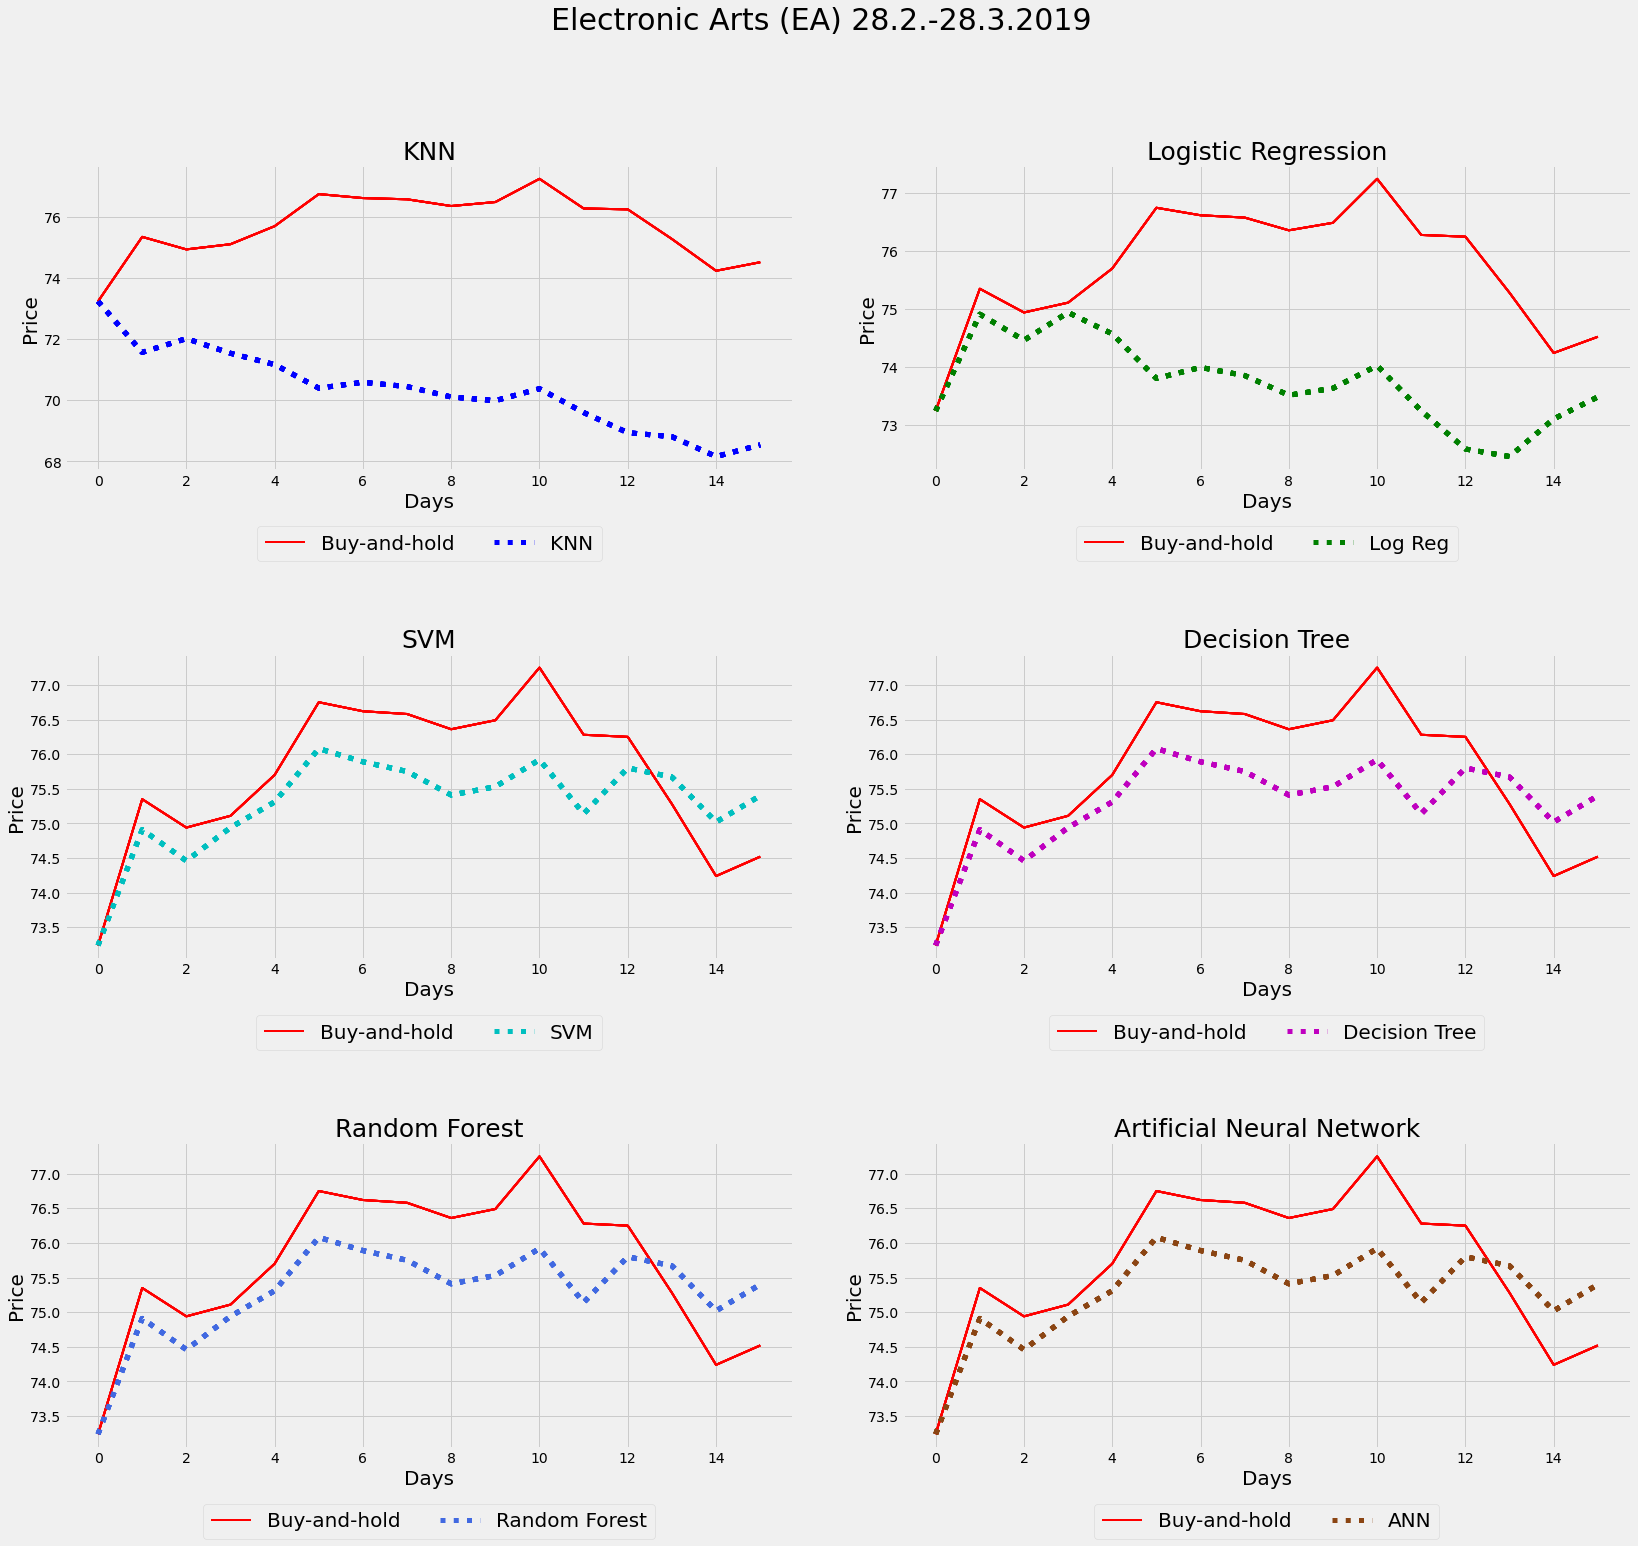

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from pylab import rcParams
plt.style.use('fivethirtyeight') 
plt.rcParams['figure.figsize'] = 25, 22 
plt.suptitle('Electronic Arts (EA) 28.2.-28.3.2019', fontsize=30)

ax1 = predictions['Adj_Close_stock']
ax2 = predictions['KNN_Result']
ax3 = predictions['LogReg_Result']
ax4 = predictions['SVM_Result']
ax5 = predictions['Decision_Tree_Result']
ax6 = predictions['Random_Forest_Result']
ax7 = predictions['ANN_Result']

for i in range (1, 7):
    plt.subplots_adjust(hspace=0.6, wspace=0.15)
        
    plt.subplot(3,2,1)
    plt.plot(ax1, 'r',  linewidth=2)
    plt.plot(ax2,  'b',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('KNN',  fontsize=25)
    a='Buy-and-hold'
    b='KNN'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,2)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax3, 'g',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Logistic Regression', fontsize=25)
    a='Buy-and-hold'
    b='Log Reg'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,3)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax4, 'c',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('SVM', fontsize=25)
    a='Buy-and-hold'
    b='SVM'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,4)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax5, 'm',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Decision Tree', fontsize=25)
    a='Buy-and-hold'
    b='Decision Tree'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,5)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax6, 'royalblue',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Random Forest', fontsize=25)
    a='Buy-and-hold'
    b='Random Forest'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,6)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax7, 'saddlebrown',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Artificial Neural Network', fontsize=25)
    a='Buy-and-hold'
    b='ANN'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)

#pylab.savefig('AAL.jpg') # Saves figure as .jpg-file
plt.show()

Thank you!